# Information retained via CDR3 compression schemes

In [1]:
import pandas as pd
import numpy as np
import pyrepseq as prs
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import pepdata.amino_acid_properties as aap
import pepdata.reduced_alphabet as ra
from aaindex import aaindex1

import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist

sns.set_theme()
sns.set_style("ticks")

from src import *

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['text.usetex'] = True
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18
mpl.rcParams['legend.fontsize'] = 20

Matplotlib is building the font cache; this may take a moment.
/Users/james/Documents/Projects/TCR-info 2022/paper_tcrinfo/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
olga = pd.read_csv('data/olga.csv.gz',sep=',').astype(str)
spc = pd.read_csv('data/spc.csv.gz',sep=',').astype(str)
epitope_meta = pd.read_csv('data/epitope_meta.csv.gz',sep=',')

In [3]:
aminoacids = 'ACDEFGHIKLMNPQRSTVWY'
three_letter_codes = ['Ala','Cys','Asp','Glu','Phe','Gly','His','Ile','Lys','Leu','Met','Asn','Pro','Gln','Arg','Ser','Thr','Val','Trp','Tyr']

## Representing the CDR3 as a bag of words vector

In [4]:
def get_aa_content(sequence, aa):
    
    content = 0
    for amino_acid in sequence:
        if amino_acid == aa:
            content += 1
    return str(content)

def make_bow_vectors(df, three_letter_codes):
    
    alpha_vector = ""
    beta_vector = ""
    for i, aminoacid in enumerate(three_letter_codes):
        if i < len(three_letter_codes)-1:
            alpha_vector += df[f"CDR3A_{aminoacid}_content"] + ","
            beta_vector += df[f"CDR3B_{aminoacid}_content"] + ","
        else:
            alpha_vector += df[f"CDR3A_{aminoacid}_content"]
            beta_vector += df[f"CDR3B_{aminoacid}_content"]
                 
    return alpha_vector, beta_vector

In [5]:
for i, aminoacid in enumerate(aminoacids):
    olga[f'CDR3B_{three_letter_codes[i]}_content'] = olga['CDR3B'].apply(lambda x: get_aa_content(x, aminoacid))
    olga[f'CDR3A_{three_letter_codes[i]}_content'] = olga['CDR3A'].apply(lambda x: get_aa_content(x, aminoacid))
    spc[f'CDR3B_{three_letter_codes[i]}_content'] = spc['CDR3B'].apply(lambda x: get_aa_content(x, aminoacid))
    spc[f'CDR3A_{three_letter_codes[i]}_content'] = spc['CDR3A'].apply(lambda x: get_aa_content(x, aminoacid))

In [6]:
olga['CDR3A_content_vector'], olga['CDR3B_content_vector'] = make_bow_vectors(olga, three_letter_codes)
spc['CDR3A_content_vector'], spc['CDR3B_content_vector'] = make_bow_vectors(spc, three_letter_codes)

In [7]:
alpha_beta_grid = np.zeros((2,2))
alpha_beta_grid[0 ,1] = alpha_beta_grid[1 ,0] = prs.renyi2_entropy(olga, 'CDR3A_content_vector')  + prs.renyi2_entropy(olga, 'CDR3B_content_vector') - prs.renyi2_entropy(spc, ['CDR3A_content_vector', 'CDR3B_content_vector'], "Epitope")
alpha_beta_grid[0 ,0] = prs.renyi2_entropy(olga, 'CDR3A_content_vector') - prs.renyi2_entropy(spc, 'CDR3A_content_vector', "Epitope")
alpha_beta_grid[1 ,1] = prs.renyi2_entropy(olga, 'CDR3B_content_vector') - prs.renyi2_entropy(spc, 'CDR3B_content_vector', "Epitope")

In [8]:
cdr3_info = prs.renyi2_entropy(olga, "CDR3A")  + prs.renyi2_entropy(olga, "CDR3B") - prs.renyi2_entropy(spc, ["CDR3A", "CDR3B"], "Epitope")
cdr3a_info = prs.renyi2_entropy(olga,  "CDR3A") - prs.renyi2_entropy(spc,  "CDR3A", "Epitope")
cdr3b_info = prs.renyi2_entropy(olga,  "CDR3B") - prs.renyi2_entropy(spc,  "CDR3B", "Epitope")

## Finding the optimal 2 letter alphabet

In [9]:
def evaluate_translation(translation, spc, back):
    
    translation_table = str.maketrans(translation)
    
    back['translation_alpha'] = back['CDR3A'].apply(lambda x: x.translate(translation_table))
    back['translation_beta'] = back['CDR3B'].apply(lambda x: x.translate(translation_table))
    spc['translation_full'] = spc['CDR3A'].apply(lambda x: x.translate(translation_table)) + "_" + spc['CDR3B'].apply(lambda x: x.translate(translation_table))
    
    return prs.renyi2_entropy(back, 'translation_alpha') + prs.renyi2_entropy(back, 'translation_beta') - prs.renyi2_entropy(spc, 'translation_full', 'Epitope')

In [10]:
def make_translation_from_list(aa_to_be_one):
    
    return {aa: '1' if aa in aa_to_be_one else '0' for aa in aminoacids}

In [11]:
def greedy_algorithm():
    
    best_amino_acids_to_be_one = []
    best_score = -np.inf
    for i in range(20):
        best_amino_acid_to_be_one = ""
        best_local_score = -np.inf
        for aa in aminoacids:
            if aa not in best_amino_acids_to_be_one:
                list_to_try = best_amino_acids_to_be_one.copy()
                list_to_try.append(aa)
                translation = make_translation_from_list(list_to_try)
                score = evaluate_translation(translation, spc, olga)
                
                if score > best_local_score:
                    best_amino_acid_to_be_one = aa
                    best_local_score = score
        
        if best_local_score <= best_score:
            print("Locally optimal set found")
            return best_amino_acids_to_be_one, best_score
        
        else:
            print(f"Improvement found, new score: {best_local_score:.1f} bits")
            best_score = best_local_score
            best_amino_acids_to_be_one.append(best_amino_acid_to_be_one)
            
    return best_amino_acids_to_be_one, best_score

In [12]:
best, score = greedy_algorithm()

Improvement found, new score: 7.8 bits
Improvement found, new score: 10.5 bits
Improvement found, new score: 12.6 bits
Improvement found, new score: 14.2 bits
Improvement found, new score: 15.0 bits
Improvement found, new score: 15.4 bits
Improvement found, new score: 15.5 bits
Improvement found, new score: 15.5 bits
Locally optimal set found


In [13]:
best, [aa for aa in aminoacids if aa not in best], score

(['G', 'S', 'Y', 'A', 'E', 'K', 'I', 'W'],
 ['C', 'D', 'F', 'H', 'L', 'M', 'N', 'P', 'Q', 'R', 'T', 'V'],
 np.float64(15.490726127510566))

In [14]:
optimal_2 = make_translation_from_list(best)

## Evaluating reduced alphabets from the literature

In [15]:
murphy_4 = {"L": "L",
             "V": "L",
             "I": "L",
             "M": "L",
             "C": "L",
             "A": "A",
             "G": "A",
             "S": "A",
             "T": "A",
             "P": "A",
             "F": "F",
             "Y": "F",
             "W": "F",
             "E": "E",
             "D": "E",
             "N": "E",
             "Q": "E",
             "K": "E",
             "R": "E",
             "H": "E"}
gbmr4 = ra.gbmr4
pc_5 = {"I": "A", # Aliphatic
         "V": "A",
         "L": "A",
         "F": "R", # Aromatic
         "Y": "R",
         "W": "R",
         "H": "R",
         "K": "C", # Charged
         "R": "C",
         "D": "C",
         "E": "C",
         "G": "T", # Tiny
         "A": "T",
         "C": "T",
         "S": "T",
         "T": "D", # Diverse
         "M": "D",
         "Q": "D",
         "N": "D",
         "P": "D"}
murphy_8 = {"L": "L",
             "V": "L",
             "I": "L",
             "M": "L",
             "C": "L",
             "A": "A",
             "G": "A",
             "S": "S",
             "T": "S",
             "P": "P",
             "F": "F",
             "Y": "F",
             "W": "F",
             "E": "E",
             "D": "E",
             "N": "E",
             "Q": "E",
             "K": "K",
             "R": "K",
             "H": "H"}
murphy10 = {"L": "L",
             "V": "L",
             "I": "L",
             "M": "L",
             "C": "C",
             "A": "A",
             "G": "G",
             "S": "S",
             "T": "S",
             "P": "P",
             "F": "F",
             "Y": "F",
             "W": "F",
             "E": "E",
             "D": "E",
             "N": "E",
             "Q": "E",
             "K": "K",
             "R": "K",
             "H": "H"}
sdm12 = ra.sdm12
murphy15  = {"L": "L",
             "V": "L",
             "I": "L",
             "M": "L",
             "C": "C",
             "A": "A",
             "G": "G",
             "S": "S",
             "T": "T",
             "P": "P",
             "F": "F",
             "Y": "F",
             "W": "W",
             "E": "E",
             "D": "D",
             "N": "N",
             "Q": "Q",
             "K": "K",
             "R": "K",
             "H": "H"}
hsdm17 = ra.hsdm17
full = {aa:aa for aa in aminoacids}

In [16]:
translations = {'gbmr \n 4': gbmr4, 'murphy \n 4': murphy_4, "pc \n 5": pc_5,
              'murphy \n 8': murphy_8, 'murphy \n 10': murphy10, 'sdm \n 12': sdm12,
              'murphy \n 15': murphy15, 'hsdm \n 17': hsdm17, 'full \n 20': full}

translation_scores = {}
for name, translation in translations.items():
    translation_scores[name] = evaluate_translation(translation, spc, olga)
    
translation_scores

{'gbmr \n 4': np.float64(17.73663898500851),
 'murphy \n 4': np.float64(19.557829432918332),
 'pc \n 5': np.float64(22.72837203672409),
 'murphy \n 8': np.float64(25.16008673364675),
 'murphy \n 10': np.float64(26.367895026275193),
 'sdm \n 12': np.float64(26.603805920507867),
 'murphy \n 15': np.float64(28.538248015773966),
 'hsdm \n 17': np.float64(29.170009146392225),
 'full \n 20': np.float64(29.80133002138598)}

## Reduced alphabets obtained via clustering with respect to biophysical properties

In [17]:
properties_df = pd.DataFrame()
properties_df['Retention coefficient in TFA'] = aaindex1['BROC820101']['values']
properties_df['Free energy of solution in water'] = aaindex1['CHAM820102']['values']
properties_df['Solvation free energy'] = aaindex1['EISD860101']['values']
properties_df['Melting point'] = aaindex1['FASG760102']['values']
properties_df['Number of hydrogen-bond donors'] = aaindex1['FAUJ880109']['values']
properties_df['Number of full nonbonding orbitals'] = aaindex1['FAUJ880110']['values']
properties_df['Partition energy'] = aaindex1['GUYH850101']['values']
properties_df['Hydration number'] = aaindex1['HOPA770101']['values']
properties_df['Retention coefficient in HPLC pH 7.4'] = aaindex1['MEEJ800101']['values']
properties_df['Retention coefficient in HPLC pH 2.1'] = aaindex1['MEEJ800102']['values']
properties_df['Partition coefficient in thin-layer chromatography'] = aaindex1['PLIV810101']['values']
properties_df['Retention coefficient at pH 2'] = aaindex1['GUOD860101']['values']

properties_df['Average volume of buried residue'] = aaindex1['CHOC750101']['values']
properties_df['Residue accessible surface area in tripeptide'] = aaindex1['CHOC760101']['values']
properties_df['Graph shape index'] = aaindex1['FAUJ880101']['values']
properties_df['Normalized Van der Waals volume'] = aaindex1['FAUJ880103']['values']
properties_df['STERIMOL length of the side chain'] = aaindex1['FAUJ880104']['values']
properties_df['STERIMOL minimum width of the side chain'] = aaindex1['FAUJ880105']['values']
properties_df['STERIMOL maximum width of the side chain'] = aaindex1['FAUJ880106']['values']
properties_df['Average accessible surface area'] = aaindex1['JANJ780101']['values']
properties_df['Distance between C alpha and centroid of side chain'] = aaindex1['LEVM760102']['values']
properties_df['Side-chain angle'] = aaindex1['LEVM760103']['values']
properties_df['Side chain torsion angle'] = aaindex1['LEVM760104']['values']
properties_df['Radius of gyration of side chain'] = aaindex1['LEVM760105']['values']
properties_df['van der Waals parameter R0'] = aaindex1['LEVM760106']['values']
properties_df['van der Waals parameter epsilon'] = aaindex1['LEVM760107']['values']
properties_df['Value of theta i'] = aaindex1['RACS820113']['values']
properties_df['Refractivity'] = aaindex1['MCMT640101']['values']

properties_df['alpha CH chemical shifts'] = aaindex1['ANDN920101']['values']
properties_df['alpha NH chemical shifts'] = aaindex1['BUNA790101']['values']
properties_df['Charge transfer capability'] = aaindex1['CHAM830107']['values']
properties_df['Charge transfer donor capability'] = aaindex1['CHAM830108']['values']
properties_df['NMR chemical shift of alpha carbon'] = aaindex1['FAUJ880107']['values']
properties_df['Localized electrical effect'] = aaindex1['FAUJ880108']['values']
properties_df['Positive charge'] = aaindex1['FAUJ880111']['values']
properties_df['Negative charge'] = aaindex1['FAUJ880112']['values']
properties_df['Polarity'] = aaindex1['GRAR740102']['values']
properties_df['Net charge'] = aaindex1['KLEP840101']['values']
properties_df['Amphiphilicity index'] = aaindex1['MITS020101']['values']
properties_df['Isoelectric point'] = aaindex1['ZIMJ680104']['values']
properties_df['Electron-ion interaction potential values'] = aaindex1['COSI940101']['values']
properties_df['pKNH2'] = aaindex1['FASG760104']['values']
properties_df['pKCOOH'] = aaindex1['FASG760105']['values']

properties_df = properties_df.drop(index='-')

In [18]:
def cluster_by_property(df, property_column, n_clusters):
    metric = pdist(df[property_column].values.reshape(-1, 1))
    linkage = sch.linkage(metric, method="ward")
    clusters = sch.fcluster(linkage, n_clusters, criterion='maxclust')
    cluster_labels = string.ascii_uppercase[:n_clusters]
    
    translation = {}
    for i, amino_acid in enumerate(df.index):
        cluster_index = clusters[i] - 1 
        translation[amino_acid] = str(cluster_labels[cluster_index])
    
    return translation

In [19]:
clusters_to_try = np.arange(2, 6)
property_scores = pd.DataFrame(index= properties_df.columns, columns=[f'{i}_cluster_score' for i in clusters_to_try])
property_scores['property_type'] = ['hydrophobic', 'hydrophobic', 'hydrophobic',
                                    'hydrophobic', 'hydrophobic', 'hydrophobic',
                                    'hydrophobic', 'hydrophobic', 'hydrophobic',
                                    'hydrophobic', 'hydrophobic', 'hydrophobic',
                                    'steric', 'steric', 'steric', 'steric', 
                                    'steric', 'steric', 'steric', 'steric',
                                    'steric', 'steric', 'steric', 'steric',
                                    'steric', 'steric', 'steric', 'steric',
                                    'electronic', 'electronic', 'electronic', 'electronic', 'electronic',
                                    'electronic', 'electronic', 'electronic', 'electronic', 'electronic',
                                    'electronic', 'electronic', 'electronic', 'electronic', 'electronic']
for n_clusters in clusters_to_try:
    for prop in properties_df.columns:
        clustered_translation = cluster_by_property(properties_df, prop, n_clusters)
        property_scores.loc[prop, f'{n_clusters}_cluster_score'] = evaluate_translation(clustered_translation, spc, olga)

## Combined plot

In [20]:
values_to_plot = property_scores.loc[['Polarity', 'Solvation free energy', 'Normalized Van der Waals volume']]['2_cluster_score'].to_dict()
values_to_plot['Optimal'] = evaluate_translation(optimal_2, spc, olga)
values_to_plot

{'Polarity': 10.078065902570422,
 'Solvation free energy': 11.19781892660139,
 'Normalized Van der Waals volume': 13.95271270810091,
 'Optimal': np.float64(15.490726127510566)}

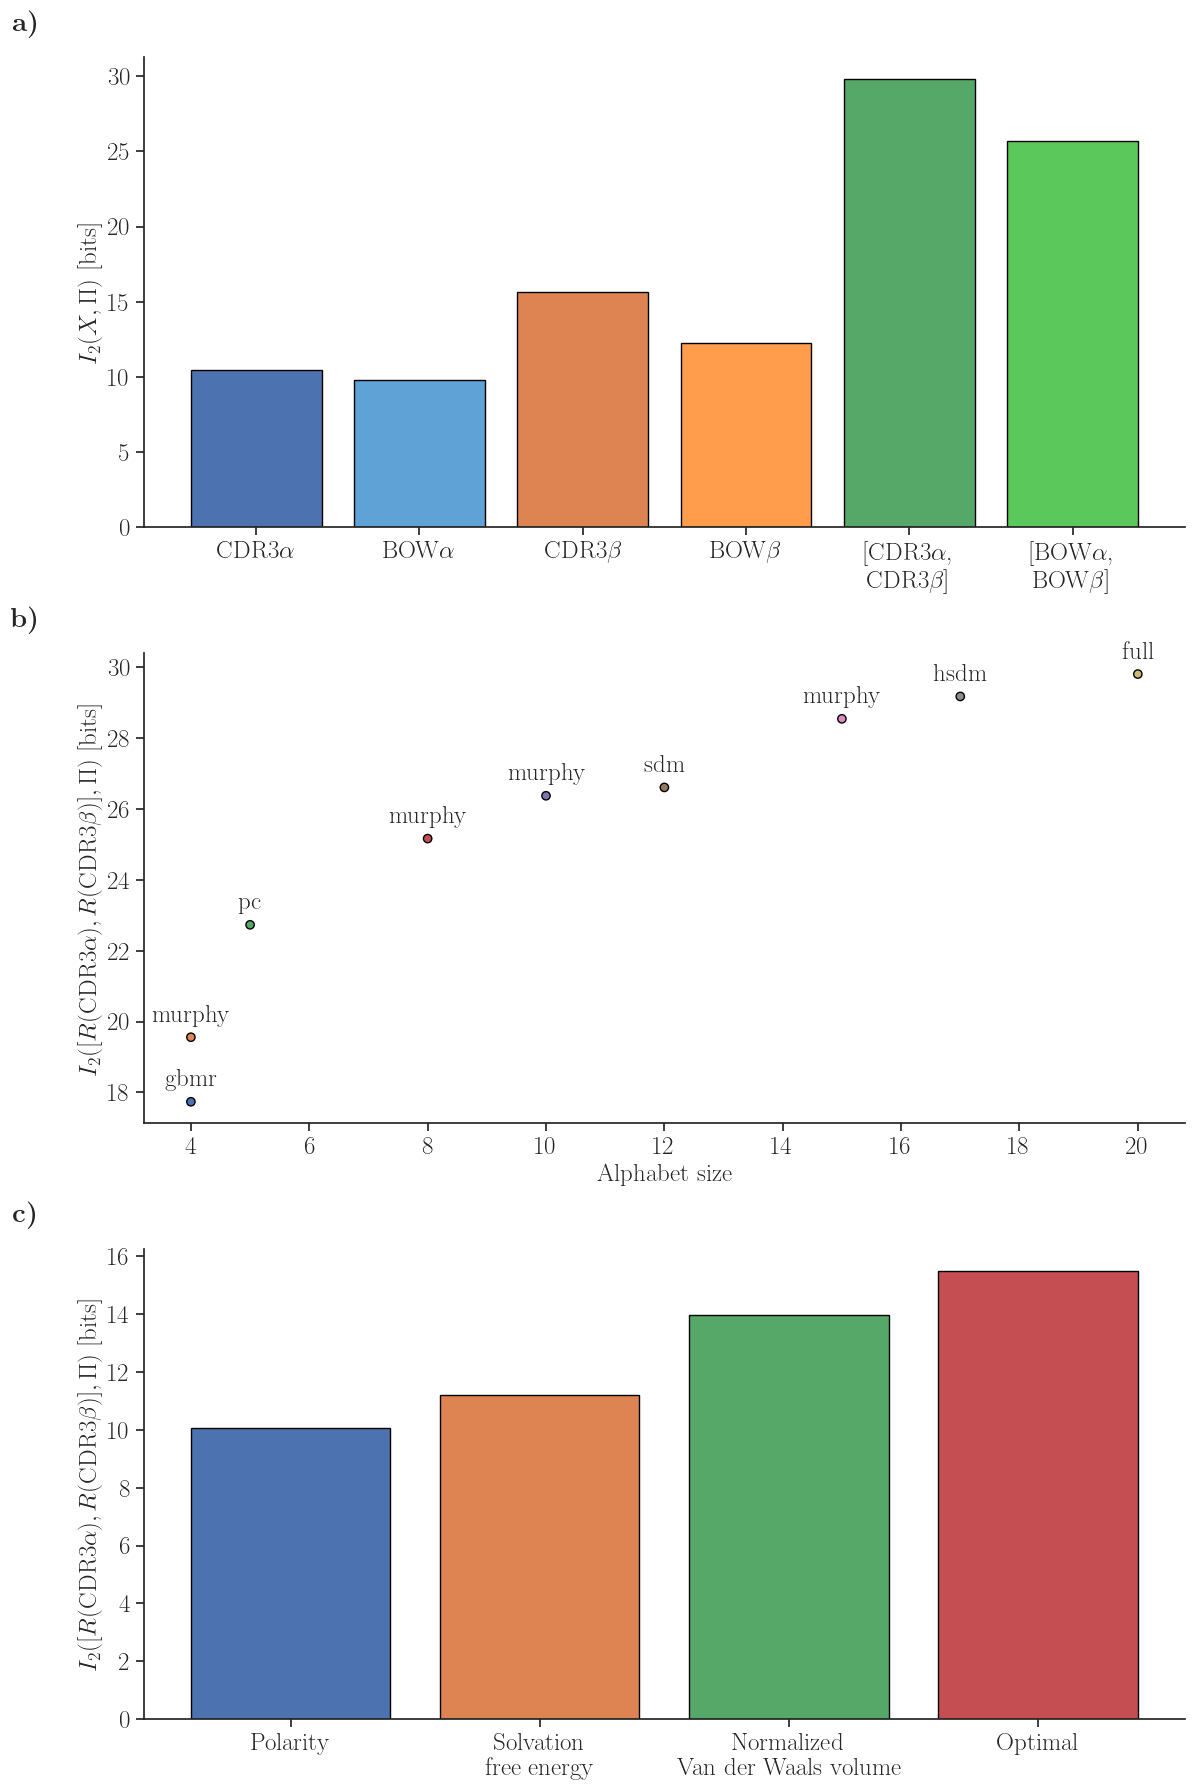

In [21]:
fig, ax = plt.subplots(3, 1, figsize=(12, 18))

labels1 = ['CDR3$\\alpha$', 'BOW$\\alpha$', 'CDR3$\\beta$', 'BOW$\\beta$', '[CDR3$\\alpha$, \n CDR3$\\beta$]', '[BOW$\\alpha$, \n BOW$\\beta$]']
values1 = [cdr3a_info, alpha_beta_grid[0][0], cdr3b_info, alpha_beta_grid[1][1], cdr3_info, alpha_beta_grid[0][1]]

colors1 = ['C0', '#5fa2d6', 'C1', '#ff9d4d', 'C2', '#5bc85b']
bars1 = ax[0].bar(labels1, values1, color=colors1, edgecolor='black')
ax[0].set_ylabel('$I_2(X, \Pi)$ [bits]')
ax[0].text(-0.1, 1.1, '\\bf a)', transform=ax[0].transAxes, fontsize=20, fontweight='bold', va='top', ha='right')

x_positions = [float(label.split('\n')[1].strip()) for label in translation_scores.keys()]
labels2 = [label.split('\n')[0].strip() for label in translation_scores.keys()]
values2 = list(translation_scores.values())
colors = [f'C{i}' for i in range(len(values2))]
scatter = ax[1].scatter(x_positions, values2, color=colors, edgecolor='black')

for i, (x, y) in enumerate(zip(x_positions, values2)):
    ax[1].text(x, y + 0.3, labels2[i], ha='center', va='bottom', fontsize=18)

ax[1].set_ylabel('$I_2([R($CDR3$\\alpha), R($CDR3$\\beta)], \Pi)$ [bits]')
ax[1].set_xlabel('Alphabet size')
ax[1].text(-0.1, 1.1, '\\bf b)', transform=ax[1].transAxes, fontsize=20, fontweight='bold', va='top', ha='right')

labels3 = ['Polarity', 'Solvation \n free energy', 'Normalized \n Van der Waals  volume', 'Optimal']
values3 = values_to_plot.values()

bars3 = ax[2].bar(labels3, values3, color=['C0', 'C1', 'C2', 'C3'], edgecolor='black')
ax[2].set_ylabel('$I_2([R($CDR3$\\alpha), R($CDR3$\\beta)], \Pi)$ [bits]')
ax[2].text(-0.1, 1.1, '\\bf c)', transform=ax[2].transAxes, fontsize=20, fontweight='bold', va='top', ha='right')
plt.tight_layout()
plt.savefig('figures/figure4.svg', bbox_inches='tight', dpi=500);